# RNA-Protein Interaction Prediction

Notebook for creation of model for prediction of RNA interacting amino acids in protein chains.

Various python imports and uses:

- **Pandas**: organizing data and storing data in tabular format
- **Numpy**: reshaping data for inputs to models
- **Matplotlib**: visualizing data
- **requests**: gathering data from RCSB.org website
- **Keras w/ tensorflow backend**: autoencoder for reducing the size of the data
- **Scikit-Learn**: Random Forest Classifier model and various metrics
- **Pymol**: used for mining data from RCSB PDB structure files of RNA-protein complexes
- **tqdm**: shows progress of various processes

In [1]:
import xml.etree.ElementTree as ET
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.models import Model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, accuracy_score

import pymol2

from tqdm import tqdm, trange

tqdm.pandas()

Using TensorFlow backend.
E:\Anaconda\envs\tf2-pymol\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Code to be applied to individual rows of Pandas DataFrame

Uses PyMol to figure out residues (individual amino acids) which are in contact/interacting with RNA. This is defined as having a distance of less than 5.0 Angstroms.

In [2]:
def pymolMine(x):
    p = pymol2.PyMOL()
    p.start()
    try:
        p.cmd.cd('./Data')
    except:
        pass
    if os.path.exists('./Data/{}.cif'.format(x['pdb'])):
        p.cmd.load('./{}.cif'.format(x['pdb']))
    else:
        p.cmd.fetch(x['pdb'])
    try:
        space = {'residues': [], 'resAll': []}
        seq = ''.join(p.cmd.get_fastastr('polymer.protein and chain {}'.format(x['chain'])).split('\n')[1:])
        if len(seq) <= 1000:
            p.cmd.iterate(
                '(polymer.protein and chain {}) within 5.0 of (polymer.nucleic and ({}))'.format(
                    x['chain'], 
                    ' or '.join(['chain {}'.format(c) for c in x['rnaChain']])
                ),
                'residues.append(resi)',
                space=space
            )
            p.cmd.iterate(
                'polymer.protein and chain {} and name CA'.format(
                    x['chain']
                ),
                'resAll.append(resi)',
                space=space
            )
            aRes = space['resAll']
            if len(seq) == len(aRes):
                pos = set(space['residues'])
                interseq = ['1' if aRes[i] in pos else '0' for i in range(len(aRes))]
                p.cmd.delete(x['pdb'])
                p.stop()
                return ''.join(interseq), seq
    except:
        pass
    p.cmd.delete(x['pdb'])
    p.stop()
    return None, None

### Main part of data mining code

A list of entities/structure file information is downloaded from the RCSB.org database in XML format. This is then 
converted into a Pandas DataFrame, removing entities which do not have at least one protein and one RNA object and have a
resolution greater than 2.5 Angstoms (half of the interaction definition). The function above is then applied to get both 
the sequence of amino acids in FASTA format (single-letter code of amino acid). The duplicate data is then dropped based on 
the combination of sequence and mined interaction and then split into three samples: training, validation, and testing 
independent based on PDB IDs so that there is no overlap within structure files.

In [3]:
def getData(maxSeqLength, maxResolution):
    # Getting the entity information
    pdbs = []
    for c in tqdm(ET.fromstring(requests.get('https://www.rcsb.org/pdb/rest/getEntityInfo').text)):
        dataPDB = {
            'pdb': c.attrib['structureId'].lower(),
            'resolution': c.attrib['resolution'] if 'resolution' in c.attrib else None,
            'proteinChain': [],
            'rnaChain': []
        }
        prt = False
        na = False
        
        # Checking requirements for protein and RNA
        for d in c:
            if d.tag == 'Method':
                dataPDB['method']  = d.attrib['name']
            elif d.tag == 'Entity':
                if d.attrib['type'] == 'protein':
                    prt = True
                elif d.attrib['type'] == 'rna':
                    na = True
                    
        # Gather relevant chain information for proteins and rna
        if na and prt:
            for d in c:
                if d.tag == 'Entity' and d.attrib['type'] == 'protein':
                    for e in d:
                        dataPDB['proteinChain'].append(e.attrib['id'])
                elif d.tag == 'Entity' and d.attrib['type'] == 'rna':
                    for e in d:
                        dataPDB['rnaChain'].append(e.attrib['id'])
            pdbs.append(dataPDB)
    
    # Put all of the relevant information into an Pandas DataFrame
    pdbsAll = pd.DataFrame([
        {
            'pdb': c['pdb'],
            'resolution': c['resolution'],
            'method': c['method'],
            'chain': d,
            'rnaChain': c['rnaChain']
        } for c in pdbs for d in c['proteinChain']
    ])
    
    # Change the resolution from string to float, get resolutions of <= 2.5 Angstroms,
    # get sequence and interaction information, drop any non-interacting chains,
    # and clean format of DataFrame
    pdbsAll['resolution'] = pdbsAll['resolution'].astype(float)
    pdbsAll = pdbsAll.loc[pdbsAll['resolution'] <= maxResolution].reset_index()
    out = pdbsAll.progress_apply(pymolMine, axis=1)
    pdbsAll['interaction'] = out.apply(lambda x: x[0])
    pdbsAll['sequence'] = out.apply(lambda x: x[1])
    pdbsAll = pdbsAll.loc[pdbsAll['interaction'].apply(lambda x: x != None and x.count('1') > 0),:]
    pdbsAll = pdbsAll.drop(columns=["index", "rnaChain"]).drop_duplicates().reset_index()
    pdbsAll = pdbsAll.drop_duplicates(subset=['interaction', 'sequence'])
    
    # Split data into three samples: training, validation, and testing
    testSamp = pdbsAll.loc[pdbsAll["pdb"].isin(np.random.choice(pdbsAll["pdb"].unique(), 100))]
    trainSamp = pdbsAll.loc[~pdbsAll.index.isin(testSamp.index)]
    valSamp = trainSamp.loc[trainSamp["pdb"].isin(np.random.choice(pdbsAll["pdb"].unique(), 100))]
    trainSamp = trainSamp.loc[~trainSamp.index.isin(valSamp.index)]
    return trainSamp, valSamp, testSamp

Using the above function and then printing out the sizes of training, validation and testing samples.

In [4]:
if os.path.exists('./train_30.csv'):
    trainSamp = pd.read_csv("train_30.csv")
    valSamp = pd.read_csv("valid_30.csv")
    testSamp = pd.read_csv("test_30.csv")
else:
    trainSamp, valSamp, testSamp = getData(1000, 3.0)
    trainSamp.to_csv("train_30.csv")
    valSamp.to_csv("valid_30.csv")
    testSamp.to_csv("test_30.csv")
print(trainSamp.shape, valSamp.shape, testSamp.shape)

(7553, 8) (748, 8) (653, 8)


## Machine Learning Model Complete Class

The following class contains both of the models for prediction (autoencoder and Random Forest Model). The following is a
description of the different properties and functions:

#### Properties

- \_encoder: Autoencoder location
- \_randomForest: Random Forest Classification model location
- maxSeqLength: maximum sequence length for the Autoencoder
- ngrams: subsequence of protein chainm to look at up and down from tested residue
  * Length of subsequence is equal to: $2 * ngrams + 1$
- \_encode_weights: Autoencoder model weights for pickling

#### Functions

- \_genEncodeData: encode data in preparation for Autoencoder model
- \_genData: generate data for training Random Forest Classifier from Pandas DataFrame sample
- \_genDataPredict: generate data for testing Random Forest Classifier from Pandas DataFrame sample
- \_genDatPredictSeq: generate data for testing individual sequence from user input for Random Forest Classifier


- fit: fit Autoencoder to sample data
- fitRandomForest: fit Random Forest Classifier to sample data while using the Autoencoder to vectorize sequence
- score: score Random Forest Classifier to input Pandas DataFrame
- predict: predict interactions using AutoEncoder and Random Forest Classifier for Pandas DataFrame
- predict_proba: predict probabilities of interaction using AutoEncoder and Random Forest Classifier for Pandas DataFrame
- predict_input: predict probabilities of interaction using AutoEncoder and Random Forest Classifier for user inputted 
  dictionary

In [5]:
class AutoEncodeRandomForest:
    def __init__(self, maxSeqLength):
        self._encoder = None
        self._randomForest = None
        self.maxSeqLength = maxSeqLength
        self.ngrams = 0
        self._encode_weights = None
        
    def _genEncodeData(self, x):
        temp = np.zeros((1,self.maxSeqLength+2,28))
        for i,v in enumerate('_'+x+'_'):
            temp[0,i,ord(v)-65 if v!= '_' else 26] = 1.0
        temp[0,i+1:,27] = 1.0
        return temp

    def _genData(self, df, M, encoder):
        out = []
        yout = []
        for c in df.index:
            seq = df.loc[c, 'sequence']
            inter = df.loc[c, 'interaction']
            seqEnc = encoder.predict(self._genEncodeData(seq))[0]
            for d in range(len(seq)):
                ind1 = d - M if d > M else 0
                ind2 = d + M + 1 if d + M < len(seq) else len(seq)
                temp = np.zeros((2*M+1,27))
                for i,v in enumerate((ind1 - d + M) * '_' + seq[ind1:ind2] + (d + M + 1 - ind2) * '_'):
                    temp[i,ord(v)-65 if v != '_' else 26] = 1.0
                out.append(np.concatenate([temp.flatten(), seqEnc], axis=0))
            yout += [float(i) for i in inter]
        return np.array(out), np.array(yout)
    
    def _genDataPredict(self, df, M, encoder):
        out = []
        for c in df.index:
            seq = df.loc[c, 'sequence']
            seqEnc = encoder.predict(self._genEncodeData(seq))[0]
            for d in range(len(seq)):
                ind1 = d - M if d > M else 0
                ind2 = d + M + 1 if d + M < len(seq) else len(seq)
                temp = np.zeros((2*M+1,27))
                for i,v in enumerate((ind1 - d + M) * '_' + seq[ind1:ind2] + (d + M + 1 - ind2) * '_'):
                    temp[i,ord(v)-65 if v != '_' else 26] = 1.0
                out.append(np.concatenate([temp.flatten(), seqEnc], axis=0))
        return np.array(out)
    
    def _genDataPredictSeq(self, seq, M, encoder):
        out = []
        seqEnc = encoder.predict(self._genEncodeData(seq))[0]
        for d in range(len(seq)):
            ind1 = d - M if d > M else 0
            ind2 = d + M + 1 if d + M < len(seq) else len(seq)
            temp = np.zeros((2*M+1,27))
            for i,v in enumerate((ind1 - d + M) * '_' + seq[ind1:ind2] + (d + M + 1 - ind2) * '_'):
                temp[i,ord(v)-65 if v != '_' else 26] = 1.0
            out.append(np.concatenate([temp.flatten(), seqEnc], axis=0))
        return np.array(out)

    def fit(self, samp, layer_size):
        X = np.concatenate(samp['sequence'].apply(self._genEncodeData).values, axis=0)
        input_layer = Input(shape=(X.shape[1],X.shape[2]))
        flatten_layer = Flatten()(input_layer)
        encoding_layer = Dense(layer_size, activation='linear')(flatten_layer)
        out_layer = Dense(X.shape[1]*X.shape[2], activation='softmax')(encoding_layer)
        reshape_layer = Reshape((X.shape[1],X.shape[2]))(out_layer)

        model = Model(inputs=[input_layer], outputs=[reshape_layer])
        self._encoder = Model(inputs=[input_layer], outputs=[encoding_layer])

        model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])
        model.fit(X, X, epochs=25, batch_size=1024, shuffle=True, verbose=True)
        self._encode_weights = self._encoder.get_weights()
        
    def fitRandomForest(self, samp, ngrams):
        self.ngrams = ngrams
        x, y = self._genData(samp, ngrams, self._encoder)
        self._randomForest = RandomForestClassifier(
            n_estimators=16,
            n_jobs=-1
        )
        self._randomForest.fit(x, y)
        
    def score(self, samp):        
        x, y = self._genData(samp, self.ngrams, self._encoder)
        return (
            self._randomForest.score(x, y),
            roc_auc_score(y, self._randomForest.predict_proba(x)[:,1]),
            average_precision_score(y, self._randomForest.predict_proba(x)[:,1]),
            x, y, self._randomForest.predict_proba(x)[:,1]
        )
    
    def predict(self, samp):
        x = self._genDataPredict(samp, self.ngrams, self._encoder)
        return self._randomForest.predict(x)
    
    def predict_proba(self, samp):
        x = self._genDataPredict(samp, self.ngrams, self._encoder)
        return self._randomForest.predict_proba(x)
    
    def predict_input(self, doc_dict):
        self._encoder.set_weights(self._encode_weights)
        x = self._genDataPredictSeq(doc_dict['sequence'], self.ngrams, self._encoder)
        res = self._randomForest.predict_proba(x)[:,1]
        out = []
        for s in range(len(doc_dict['sequence'])):
            out.append({
                'resabbrev': doc_dict['sequence'][s],
                'interaction': res[s]
            })
        return out

### Create AutoEncodeRandomForest Object and train the Autoencoder

In [6]:
m = AutoEncodeRandomForest(1000)
m.fit(trainSamp, 200)

Epoch 1/25
7553/7553 [==============================] - ETA: 16s - loss: 3.3331 - accuracy: 0.032 - ETA: 13s - loss: 3.2566 - accuracy: 0.088 - ETA: 10s - loss: 2.5462 - accuracy: 0.332 - ETA: 8s - loss: 2.0923 - accuracy: 0.456 - ETA: 5s - loss: 1.8119 - accuracy: 0.52 - ETA: 3s - loss: 1.6228 - accuracy: 0.57 - ETA: 0s - loss: 1.4828 - accuracy: 0.61 - 18s 2ms/step - loss: 1.4398 - accuracy: 0.6255
Epoch 2/25
7553/7553 [==============================] - ETA: 14s - loss: 0.6516 - accuracy: 0.823 - ETA: 12s - loss: 0.6392 - accuracy: 0.827 - ETA: 10s - loss: 0.6341 - accuracy: 0.828 - ETA: 8s - loss: 0.6299 - accuracy: 0.828 - ETA: 5s - loss: 0.6242 - accuracy: 0.82 - ETA: 3s - loss: 0.6198 - accuracy: 0.83 - ETA: 0s - loss: 0.6117 - accuracy: 0.83 - 18s 2ms/step - loss: 0.6122 - accuracy: 0.8330
Epoch 3/25
7553/7553 [==============================] - ETA: 15s - loss: 0.5833 - accuracy: 0.835 - ETA: 12s - loss: 0.5660 - accuracy: 0.840 - ETA: 10s - loss: 0.5541 - accuracy: 0.843 - ETA:

7553/7553 [==============================] - ETA: 14s - loss: 0.1013 - accuracy: 0.972 - ETA: 12s - loss: 0.1003 - accuracy: 0.972 - ETA: 10s - loss: 0.1010 - accuracy: 0.972 - ETA: 7s - loss: 0.1006 - accuracy: 0.973 - ETA: 5s - loss: 0.0987 - accuracy: 0.97 - ETA: 3s - loss: 0.0981 - accuracy: 0.97 - ETA: 0s - loss: 0.0977 - accuracy: 0.97 - 18s 2ms/step - loss: 0.0978 - accuracy: 0.9737
Epoch 22/25
7553/7553 [==============================] - ETA: 15s - loss: 0.0945 - accuracy: 0.974 - ETA: 12s - loss: 0.0940 - accuracy: 0.974 - ETA: 10s - loss: 0.0902 - accuracy: 0.975 - ETA: 8s - loss: 0.0931 - accuracy: 0.975 - ETA: 5s - loss: 0.0916 - accuracy: 0.97 - ETA: 3s - loss: 0.0911 - accuracy: 0.97 - ETA: 0s - loss: 0.0920 - accuracy: 0.97 - 18s 2ms/step - loss: 0.0921 - accuracy: 0.9754
Epoch 23/25
7553/7553 [==============================] - ETA: 14s - loss: 0.0865 - accuracy: 0.976 - ETA: 12s - loss: 0.0929 - accuracy: 0.974 - ETA: 10s - loss: 0.0924 - accuracy: 0.975 - ETA: 7s - los

### Test Random Forest Classifier at different subsequence sizes

In [7]:
for i in range(11):
    m.fitRandomForest(trainSamp, i)
    acc, auroc, auprc, xTest, yTest, yPred = m.score(trainSamp)
    print(i, acc, auroc, auprc)
    acc, auroc, auprc, xTest, yTest, yPred = m.score(valSamp)
    print(i, acc, auroc, auprc)
    print()

0 0.8032233899871262 0.8532424943042831 0.7236366427495908
0 0.7857467956717711 0.8161801813542617 0.6647942494099299

1 0.9698324907782457 0.9965495173127508 0.991889902321399
1 0.8931963999941273 0.9469468033604608 0.8993369140853281

2 0.9771037337077358 0.9975834868964274 0.9942757494861103
2 0.8980854781166038 0.9501329147115813 0.9041805942546381

3 0.977276431334377 0.9976181212049152 0.9943559899391397
3 0.898687436684236 0.9489554916079712 0.9025954973096826

4 0.9773452113415242 0.9976388258538573 0.9944006633528495
4 0.8997812394473726 0.950629550591595 0.9057468864083718

5 0.9773429685152041 0.9976501705562854 0.9944253253345019
5 0.8982763430282921 0.9525014618505507 0.9074365697192829

6 0.9773878250416044 0.9976538217678463 0.9944387071041545
6 0.8985039127306896 0.9472449098016162 0.9022738360878162

7 0.9773556778643508 0.9976628372588536 0.9944562297639195
7 0.9000014681916284 0.9509537146129953 0.9053773879962441

8 0.9773549302555775 0.9976731129912595 0.9944756668

### Train final model based on previous analysis and visualize results

0.9304170161873043 0.9617520348317842 0.9276959143865426


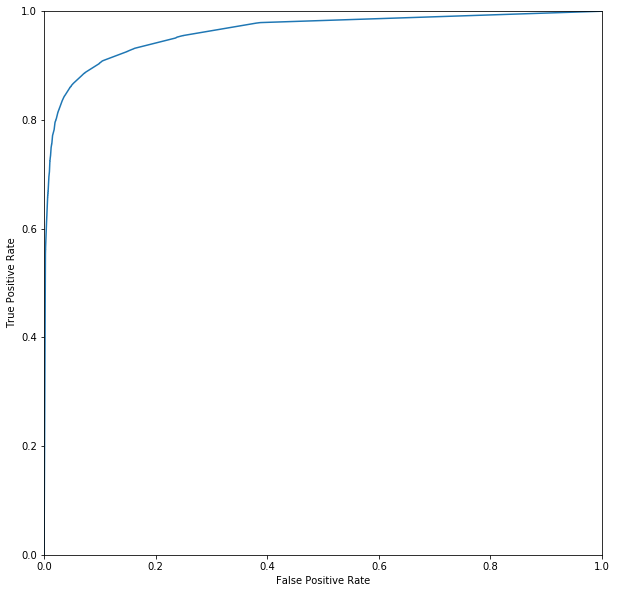

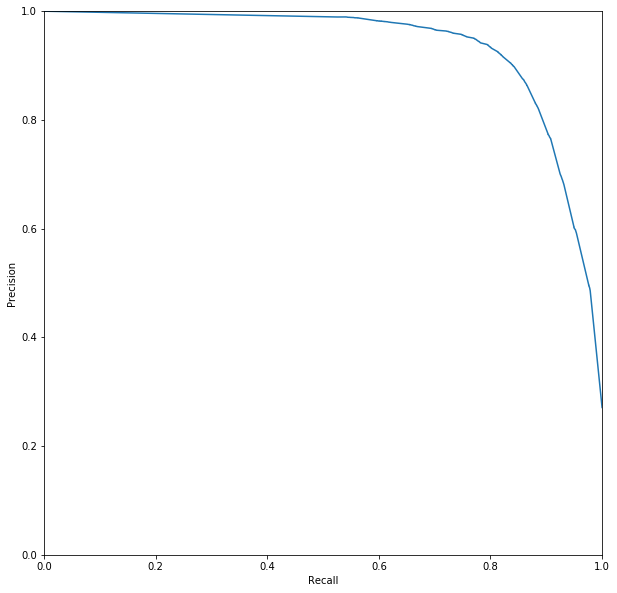

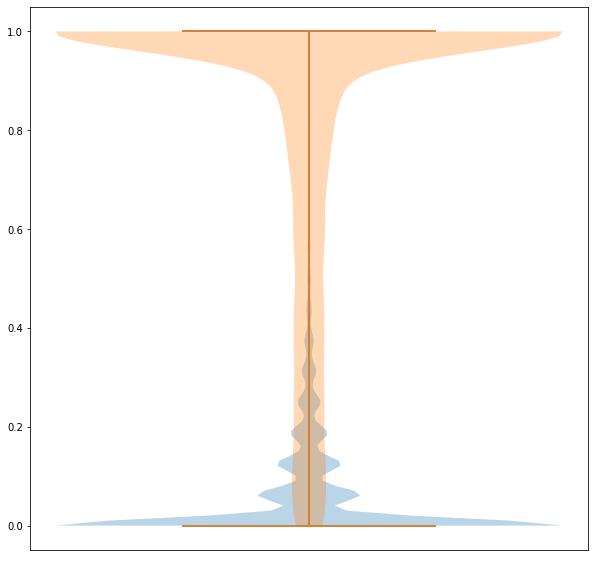

In [18]:
m.fitRandomForest(trainSamp, 7)
acc, auroc, auprc, xTest, yTest, yPred = m.score(testSamp)
print(acc, auroc, auprc)

fpr, tpr, _ = roc_curve(yTest, yPred)
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.show()

precision, recall, _ = precision_recall_curve(yTest, yPred)
plt.figure(figsize=(10,10))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.show()

plt.figure(figsize=(10,10))
plt.violinplot(yPred[yTest==0.])
plt.violinplot(yPred[yTest==1.])
plt.xticks([])
plt.show()

### Pickle AutoEncodeRandomForest object

In [19]:
with open('model_rnaprotein.pkl', 'wb') as fp:
    pickle.dump(m, fp)